In [1]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.9', '1.1.8')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & Dataloader

Karena CNN jangan lupa N, C, H, w. In this case 128 data x 3 channel x 64 x 64. Jangan di Flatten!

Data pipeline nya

Data ==> Augmentasi 1 ==> Augmentasi 2 ==> Augmentasi 3 ==> ToTensor()

Untuk pemilihan augmentasi depend dari kasus nya

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [8]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [9]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config 

Ada 2 fase di CNN, Feature Extractor => Fully Connected

In [10]:
# Kalau manual tanpa block, library dari jcopdl

# nn.Conv2d(3, 8, 3, 1, 1),
# nn.ReLU(),
# nn.MaxPool2d(2, 2)

In [12]:
from jcopdl.layers import conv_block, linear_block

In [13]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature Extractor
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        # Fully Connected
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1), # Nilai 1024 didapatkan dari 64 x sisa fitur yang di MaxPool, in this case fitur nya sisa 4 x 4
            linear_block(256, 2, activation='lsoftmax')
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [14]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation => MCOC

In [16]:
model = CustomCNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training Loop 

In [17]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Test: 100%|████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.63it/s]



Epoch     1
Train_cost  = 0.6935 | Test_cost  = 0.6895 | Train_score = 0.5010 | Test_score = 0.5000 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6813 | Test_cost  = 0.6594 | Train_score = 0.5730 | Test_score = 0.7175 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6233 | Test_cost  = 0.5547 | Train_score = 0.7010 | Test_score = 0.7250 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5523 | Test_cost  = 0.5326 | Train_score = 0.7230 | Test_score = 0.7575 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5301 | Test_cost  = 0.5122 | Train_score = 0.7400 | Test_score = 0.7475 |
==> EarlyStop patience =  1 | Best test_score: 0.7575


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5245 | Test_cost  = 0.4898 | Train_score = 0.7520 | Test_score = 0.7725 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.5059 | Test_cost  = 0.5186 | Train_score = 0.7600 | Test_score = 0.7625 |
==> EarlyStop patience =  1 | Best test_score: 0.7725


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4933 | Test_cost  = 0.4681 | Train_score = 0.7680 | Test_score = 0.8000 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4853 | Test_cost  = 0.4670 | Train_score = 0.7730 | Test_score = 0.8000 |
==> EarlyStop patience =  1 | Best test_score: 0.8000


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4876 | Test_cost  = 0.5216 | Train_score = 0.7720 | Test_score = 0.7500 |
==> EarlyStop patience =  2 | Best test_score: 0.8000


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4875 | Test_cost  = 0.4590 | Train_score = 0.7570 | Test_score = 0.8025 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4757 | Test_cost  = 0.4382 | Train_score = 0.7750 | Test_score = 0.8000 |
==> EarlyStop patience =  1 | Best test_score: 0.8025


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4636 | Test_cost  = 0.4379 | Train_score = 0.7880 | Test_score = 0.8075 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.4625 | Test_cost  = 0.4524 | Train_score = 0.7860 | Test_score = 0.8125 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.4716 | Test_cost  = 0.4399 | Train_score = 0.7720 | Test_score = 0.8200 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4645 | Test_cost  = 0.4762 | Train_score = 0.7820 | Test_score = 0.7625 |
==> EarlyStop patience =  1 | Best test_score: 0.8200


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.4438 | Test_cost  = 0.4484 | Train_score = 0.8000 | Test_score = 0.7825 |
==> EarlyStop patience =  2 | Best test_score: 0.8200


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.4251 | Test_cost  = 0.4192 | Train_score = 0.8130 | Test_score = 0.8000 |
==> EarlyStop patience =  3 | Best test_score: 0.8200


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.4044 | Test_cost  = 0.4096 | Train_score = 0.8180 | Test_score = 0.8250 |


Test: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]



Epoch    20
Train_cost  = 0.3853 | Test_cost  = 0.4296 | Train_score = 0.8310 | Test_score = 0.7925 |


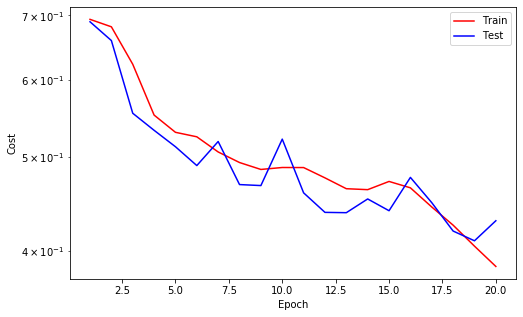

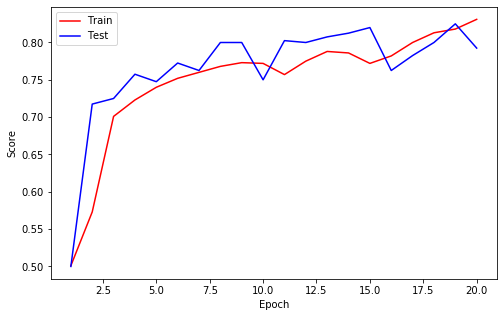

Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]

==> EarlyStop patience =  1 | Best test_score: 0.8250


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3876 | Test_cost  = 0.4044 | Train_score = 0.8230 | Test_score = 0.8275 |


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3986 | Test_cost  = 0.4099 | Train_score = 0.8140 | Test_score = 0.8175 |
==> EarlyStop patience =  1 | Best test_score: 0.8275


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.4037 | Test_cost  = 0.4509 | Train_score = 0.8190 | Test_score = 0.7750 |
==> EarlyStop patience =  2 | Best test_score: 0.8275


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3796 | Test_cost  = 0.3755 | Train_score = 0.8290 | Test_score = 0.8175 |
==> EarlyStop patience =  3 | Best test_score: 0.8275


Train:   0%|                                                       | 0/8 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3989 | Test_cost  = 0.4723 | Train_score = 0.8210 | Test_score = 0.7625 |
==> EarlyStop patience =  4 | Best test_score: 0.8275


Test: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]



Epoch    26
Train_cost  = 0.4049 | Test_cost  = 0.4742 | Train_score = 0.8130 | Test_score = 0.7725 |
==> EarlyStop patience =  5 | Best test_score: 0.8275
==> Execute Early Stopping at epoch: 26 | Best test_score: 0.8275
==> Best model is saved at model


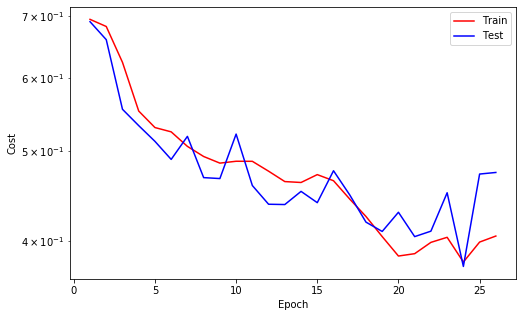

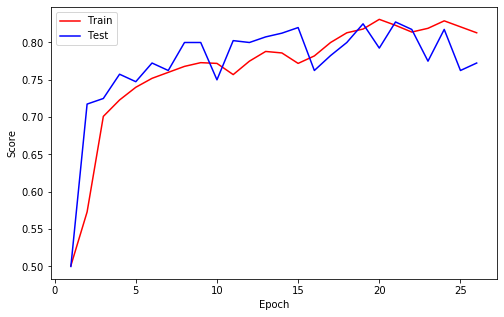

In [18]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict 

In [19]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [22]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')

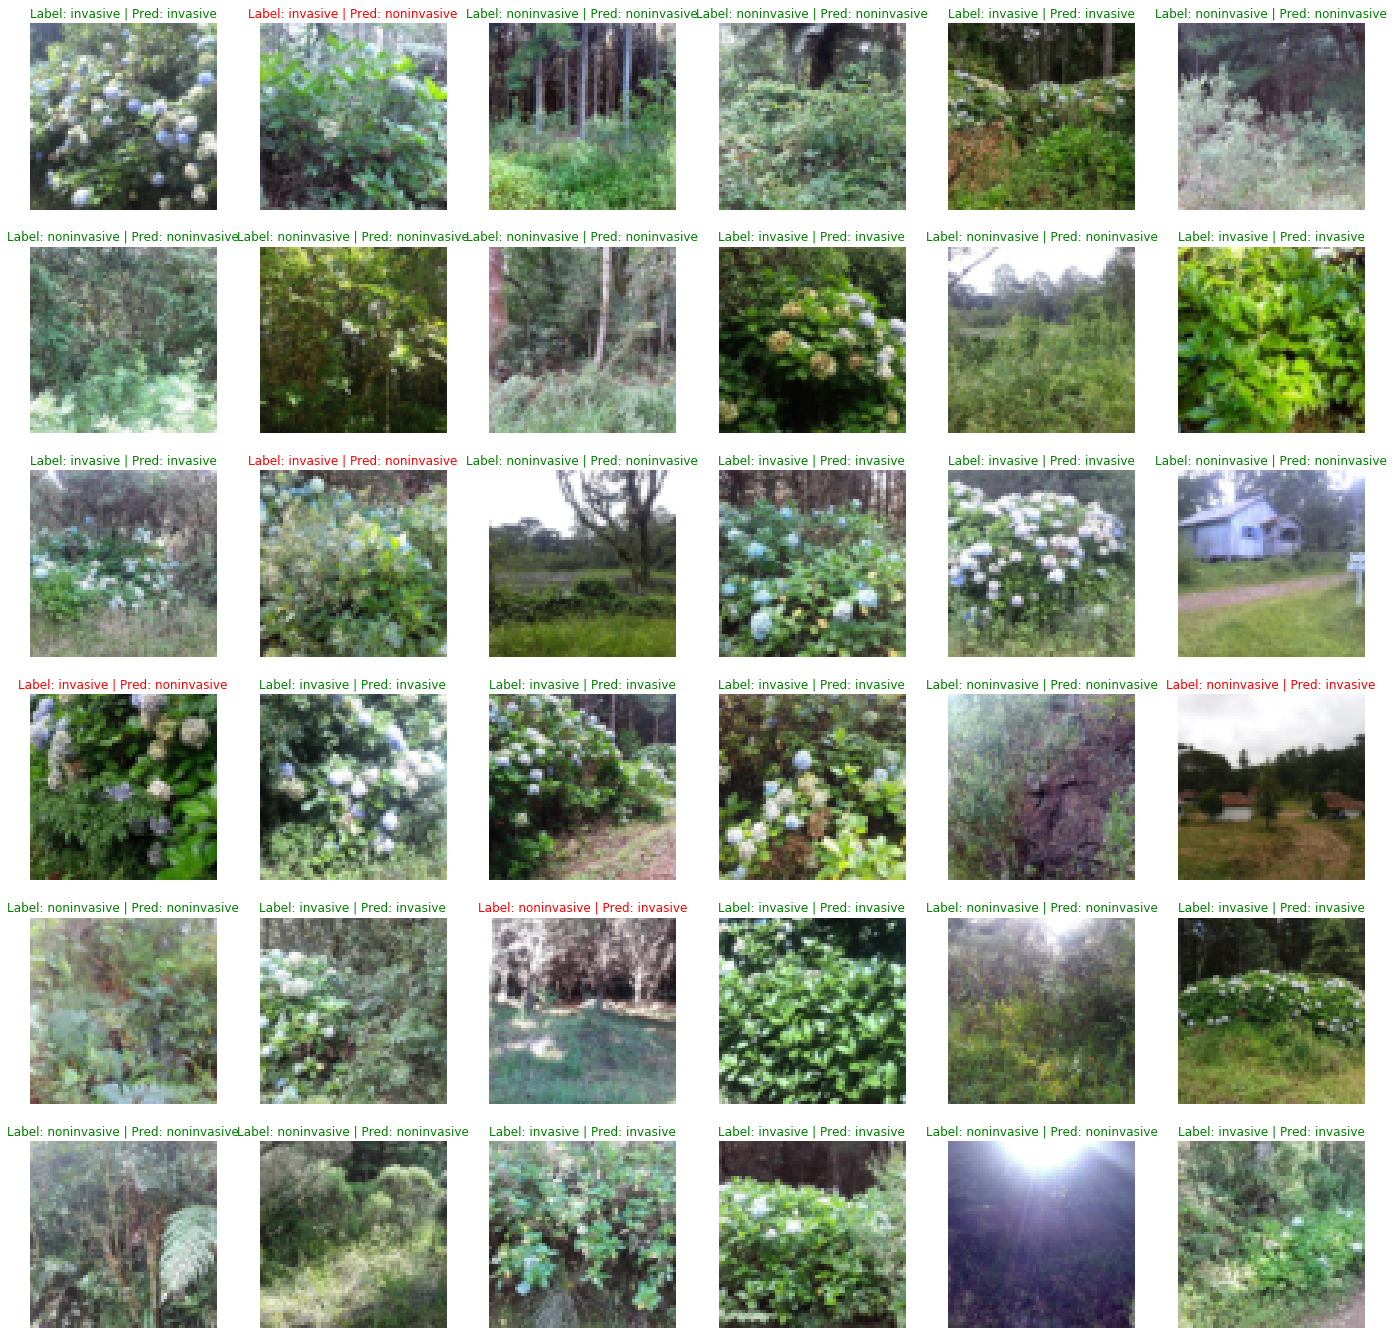

In [27]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
    ax.axis('off');